In [254]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter
from thop import profile
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from scipy import interp
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, auc, confusion_matrix
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.__version__)

1.7.0+cu110


In [62]:
def train_model(model, optimizer, loss, num_epoches=100, verbose=10, writer=None):
    '''
    输入
    model: 需要训练的模型
    optimizer: 优化器
    loss: 损失函数
    num_epoches: 训练次数
    verbose: 训练信息的打印间隔
    writer：训练过程记录

    输出
    model: 训练完成的模型
    accuracy_train: 训练集正确率
    accuracy_test: 测试集正确率
    '''
    model.train()
    dur = []
    for epoch in range(1, num_epoches+1):
        # if epoch >= 3:
        #     t0 = time.time()
        loss_train, n, total_acc = 0.0, 0, 0
        t0 = time.time()
        for X, y  in trainloader:
            X = X.to(device)
            y = y.to(device)
            y_pred_proba = model(X)
            l = loss(y_pred_proba, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            loss_train += l.item()
            n += y.shape[0]
            y_pred = torch.argmax(y_pred_proba, axis=1)
            total_acc += torch.sum(y==y_pred).item()

        dur.append(time.time() - t0)
        accuracy_train = total_acc / n
        accuracy_test, loss_test = eval_test(model, loss)

        if writer:
            writer.add_scalar('Loss/Train', loss_train, epoch)
            writer.add_scalar('Loss/Test', loss_test, epoch)
            writer.add_scalar('Accuracy/Train', accuracy_train, epoch)
            writer.add_scalar('Accuracy/Test', accuracy_test, epoch)
        if verbose > 0 and epoch % verbose == 0:
            print("Epoch {:05d} | Loss {:.4f} | accuracy_train {:.4f} | accuracy_test {:.4f} | Time(s) {:.4f}".format(
                epoch, loss_train, accuracy_train, accuracy_test, np.mean(dur)))
    if writer:
        writer.add_graph(model, (X,))
    writer.close()
    return model, accuracy_train, accuracy_test

In [63]:
def eval_test(model, loss):
    '''
    输入:
    model: 需要进行测试的模型

    输出:
    测试集正确率
    '''
    model.eval()
    l_sum, n, total_acc = 0.0, 0, 0
    for X, y  in testloader:
        X = X.to(device)
        y = y.to(device)
        y_pred_proba = model(X)
        n += y.shape[0]
        y_pred = torch.argmax(y_pred_proba, axis=1)
        total_acc += torch.sum(y==y_pred).item()
        l_sum += loss(y_pred_proba, y).item()
    return total_acc/n, l_sum

#### 读取训练集 & 测试集

In [64]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)# 对数据进行标准化 [0, 1] -> [-1, 1]

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, 
                                        transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, 
                                        transform=transform)

Files already downloaded and verified
Files already downloaded and verified


trainset 样本数：50000

testset 样本数：10000

样本维度：n_channels = 3
         height = 32
         width = 32

In [65]:
batch_size = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=0)
calsses = ['plane', 'cat', 'bird', 'cat', 'deer', 'dog', 'frog',
           'horse', 'ship', 'truck']

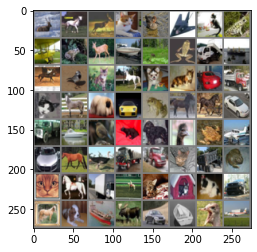

In [66]:
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

#### Transformer Encoder

In [67]:
class ScaledDotProductAttention(nn.Module):
    def __init_():
        super(ScaledDotProductAttention, self).__init_()
    
    def forward(self, Q, K, V):
        # K (batch_size, n_heads, len_k, d_k)
        # Q (batch_size, n_heads, len_q(=len_k), d_q(=d_k))
        # V (batch_size, n_heads, len_v(=len_k), d_v)
        d_k = K.shape[-1]
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k)
        # scores(batch_size, n_heads, len_q, len_k)
        # scores.masked_fill(attn_mask, -1e9)
        attn = F.softmax(scores, dim=-1)
        contexts = torch.matmul(attn, V)
        # contexts (batch_size, n_heads, len_v(=len_k), d_v)
        return contexts, attn

In [68]:
class MultHeadAttention(nn.Module):
    def __init__(self, d_model, d_k, d_v, n_heads):
        super(MultHeadAttention, self).__init__()
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)
        self.fc = nn.Linear(n_heads * d_v, d_model)
        self.layer_norm = nn.LayerNorm(d_model)
    
    def forward(self, Q, K, V):
        # K (batch_size, len_k, d_model)
        # Q (batch_size, len_q(=len_k), d_model)
        
        # V (batch_size, len_v(=len_k), d_model)
        residual, batch_size = Q, Q.shape[0]
        q = self.W_Q(Q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        k = self.W_K(K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        v = self.W_V(V).view(batch_size, -1, self.n_heads, self.d_v).transpose(1, 2)
        # attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1)
        # attn_mask (batch_size, n_heads, len_k, len_q)
        context, attn = ScaledDotProductAttention()(q, k, v)
        # contexts (batch_size, n_heads, len_v(=len_k), d_v)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_v)
        # contexts (batch_size, len_v(=len_k), n_heads * d_v)
        output = self.fc(context)
        # output (batch_size, len_v(=len_k), d_model)
        output = output + residual
        return self.layer_norm(output), attn


In [69]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_model):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.fc1 = nn.Linear(d_model, d_model)
        self.fc2 = nn.Linear(d_model, d_model)
        self.layer_norm = nn.LayerNorm(d_model)
    def forward(self, inputs):
        # inputs (batch_size, len_q, d_model)
        residual = inputs
        output = self.fc1(inputs)
        output = F.relu(output)
        output = self.fc2(output)
        return self.layer_norm(output + residual)

In [70]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_k, d_v, n_heads):
        super(EncoderLayer, self).__init__()
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.enc_self_attn = MultHeadAttention(d_model, d_k, d_v, n_heads)
        self.pos_ffn = PoswiseFeedForwardNet(d_model)
    
    def forward(self, enc_inputs):
        # enc_inputs (batch_size, len_k, d_model)
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs)
        enc_outputs = self.pos_ffn(enc_outputs)
        # enc_outputs (batch_size, len_q, d_model)
        return enc_outputs, attn

In [71]:
class Encoder(nn.Module):
    def __init__(self, n, d_model, d_k, d_v, n_heads, n_layers):
        super(Encoder, self).__init__()
        # self.src_emb = nn.Embedding(n, d_model)
        # self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(n+1, d_model),freeze=True)
        self.n_layers = n_layers
        self.layers = nn.ModuleList([EncoderLayer(d_model,d_k, d_v, n_heads) for _ in range(n_layers)])
        # self.position = torch.LongTensor([[i for i in range(1, n+1)]]).to(device)
        self.position = nn.Parameter(torch.randn(1, n+1, d_model))
    def forward(self, enc_inputs):
        # enc_inputs (batch_size, h*w, patch_height*patch_width*in_channels)
        # enc_outputs = self.src_emb(enc_inputs) + self.pos_emb(torch.LongTensor([[1,2,3,4,0]]))
        batch_size, n, _ = enc_inputs.shape
        # pos_emb_vec = self.pos_emb(self.position)
        enc_outputs = enc_inputs + self.position[:, :n]
        # enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)
        enc_self_attns = []
        for layer in self.layers:
            enc_outputs, enc_self_attn = layer(enc_outputs)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns

#### VGG16

In [72]:
class vgg_cell(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3,
                stride=1, padding=1, pool=False, kernel_size_pool=2,
                stride_pool=2, padding_pool=0):
        super(vgg_cell, self).__init__()
        self.net = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ])
        if pool:
            self.net.append(nn.MaxPool2d(kernel_size=kernel_size_pool,
                                         stride=stride_pool,
                                         padding=padding_pool))
        self.net = nn.Sequential(*self.net)
    def forward(self, x):
        # x: (batch_size, n_channels, h, w)
        x = self.net(x)
        return x

class vgg(nn.Module):
    def __init__(self, config, num_classes=10):
        super(vgg, self).__init__()
        self.num_classes = num_classes
        self.net = nn.ModuleList([])
        for in_channels, out_channels, kernel_size, stride, padding, pool in config:
            self.net.append(vgg_cell(in_channels=in_channels,
                                     out_channels=out_channels,
                                     kernel_size=kernel_size,
                                     stride=stride,
                                     padding=padding,
                                     pool=pool))
        # self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
        # self.fc1 = nn.Linear(25088, 4096, bias=True)
        # self.fc2 = nn.Linear(4096, 4096, bias=True)
        # self.fc3 = nn.Linear(4096, 1000, bias=True)
        self.output_layer = nn.Linear(512, self.num_classes)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x, mlp=True):
        batch_size = x.shape[0]
        for cell in self.net:
            x = cell(x)
        if mlp:
            x = x.view(batch_size, -1)
            x = self.output_layer(x)
        return x

#### ViT

In [84]:
class ViT(nn.Module):
    def __init__(self, image_size, in_channels, patch_size, num_classes, 
                 dim, depth, heads, mlp_dim, d_k=64, d_v=64, 
                 dropout=0, emb_dropout=0):
        super(ViT, self).__init__()
        image_height, image_width = image_size
        patch_height, patch_width = patch_size
        num_pathes = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = in_channels * patch_height * patch_width
        self.num_pathes = num_pathes
        self.patch_dim = patch_dim
        self.to_patch_layer = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_height, p2=patch_width),
            nn.Linear(patch_dim, dim)
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = Encoder(n=num_pathes+1,
                                    d_model=dim, 
                                    d_k=d_k, 
                                    d_v=d_v, 
                                    n_heads=heads, 
                                    n_layers=depth)
        # self.transformer_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads)
        # self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=depth, norm=nn.LayerNorm(dim))
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )
    
    def forward(self, img):
        batch_size = img.shape[0]
        # img = img.view(batch_size, self.num_pathes, self.patch_dim)
        x = self.to_patch_layer(img)
        # cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=batch_size)
        # x = torch.cat((cls_tokens, x), dim=1)
        x = self.dropout(x)
        x, _ = self.transformer(x)
        x = x.mean(axis=1)
        x = self.mlp_head(x)
        return x

#### ViT FLOPs

In [74]:
def calc_vit_flops(vit_params, batch_size):
    in_channels = vit_params['in_channels']
    patch_height, patch_width = vit_params['patch_size']
    image_height, image_width = vit_params['image_size']
    num_pathes = (image_height // patch_height) * (image_width // patch_width)
    patch_dim = in_channels * patch_height * patch_width

    d_model = vit_params['dim']
    num_classes = vit_params['num_classes']
    d_k = vit_params['d_k']
    d_q = d_k
    d_v = vit_params['d_v']
    heads = vit_params['heads']
    depth = vit_params['depth']
    len_k, len_q, len_v = num_pathes, num_pathes, num_pathes

    '''
    batch_size * patch_dim * d_model +
    (拉平操作)

    (batch_size * d_model * heads * (len_k * d_k + len_q * d_q + len_v * d_v) + 
    (生成 key, query, value矩阵)

    batch_size * heads * len_q * d_k * len_k + 
    (使用key, query计算attention)

    batch_size * heads * len_q * len_k * d_v + batch_size * len_q * heads * d_v * d_model + 
    (使用attention, value计算 output)

    batch_size * len_q * d_model * d_model * 2) * depth + 
    (FeedForward)

    batch_size * d_model * num_classes
    (最终输出)
    '''

    FLOPs = batch_size * patch_dim * d_model + \
            (batch_size * d_model * heads * (len_k * d_k + len_q * d_q + len_v * d_v) + \
            batch_size * heads * len_q * d_k * len_k + \
            batch_size * heads * len_q * len_k * d_v + batch_size * len_q * heads * d_v * d_model + \
            batch_size * len_q * d_model * d_model * 2) * depth + \
            batch_size * d_model * num_classes

    return FLOPs

vit_params = {
            'image_size': (8, 8), 
            'in_channels': 128, 
            'patch_size': (1, 1), 
            'num_classes': 10, 
            'dim': 128, 
            'depth': 5, 
            'heads': 4,
            'mlp_dim': 128, 
            'd_k': 32,
            'd_v': 32, 
            'dropout': 0}
img = torch.randn(1, 128, 8, 8)
model_vit = ViT(**vit_params)
print(calc_vit_flops(vit_params, 1))
flops, params = profile(model_vit, inputs=(img, ))
print(flops, params)

36717824
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.normalization.LayerNorm'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.MultHeadAttention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.PoswiseFeedForwardNet'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.EncoderLayer'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Encoder'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.ViT'>. Treat it as zero Macs and z

### Model A

In [98]:
class vgg_vit(nn.Module):
    def __init__(self, vgg_params, vit_params):
        super(vgg_vit, self).__init__()
        self.vgg = vgg(**vgg_params)
        self.vit = ViT(**vit_params)
    def forward(self, img):
        x = self.vgg(img, mlp=False)
        x = self.vit(x)
        return x

vgg_params ={
    'config': [
    (3, 64, 3, 1, 1, False),    #3 3
    (64, 64, 3, 1, 1, True),    #4 7
    (64, 128, 3, 1, 1, False),  #3 10
    (128, 128, 3, 1, 1, True),  #4 14
    # (128, 256, 3, 1, 1, False), #3 17
    # (256, 256, 3, 1, 1, False), #3 20
    # (256, 256, 3, 1, 1, True),  #4 24
    # (256, 512, 3, 1, 1, False), #3 27
    # (512, 512, 3, 1, 1, False), #3 30
    # (512, 512, 3, 1, 1, True),  #4 34
    # (512, 512, 3, 1, 1, False), #3 37
    # (512, 512, 3, 1, 1, False), #3 40
    # (512, 512, 3, 1, 1, True),  #4 44
    ], 
    'num_classes': 10
    }

vit_params = {
            'image_size': (8, 8), 
            'in_channels': 128, 
            'patch_size': (1, 1), 
            'num_classes': 10, 
            'dim': 128, 
            'depth': 5, 
            'heads': 4,
            'mlp_dim': 128, 
            'd_k': 32,
            'd_v': 32, 
            'dropout': 0}
'''
卷积层输入为(batch_size, 3, 32, 32)
卷积层输出为(batch_size, 128, 8, 8)
Transformer输入为(batch_size, 128, 8, 8) -> (batch_size, 64, 128)
'''
model_A = vgg_vit(vgg_params, vit_params).to(device)
model_vgg = vgg(**vgg_params).to(device)

In [99]:
img = torch.randn(1, 3, 32, 32).to(device)
vgg_flops, vgg_params_num = profile(model_vgg, inputs=(img, False))
vit_flops = calc_vit_flops(vit_params, 1)
model_A_flops = vgg_flops + vit_flops
_, model_A_params_num = profile(model_A, inputs=(img, ))
print('Model A Params Num: ', model_A_params_num)
print('Model A FLOPS: ', model_A_flops)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.vgg_cell'>. Treat it as zero Macs and zero Params.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class '__main__.vgg'>. Treat it as zero Macs and zero Params.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 't

训练模型

In [100]:
month = time.localtime().tm_mon
day = time.localtime().tm_mday
hour = time.localtime().tm_hour
minute = time.localtime().tm_min
img = torch.randn(1, 3, 32, 32).to(device)
loss = nn.CrossEntropyLoss()
optimizer_A = optim.Adam(model_A.parameters(), lr=1e-3, weight_decay=5e-5)
writer_A = SummaryWriter(log_dir=f'./logs/A/{month}-{day}-{hour}-{minute}', comment='A')
save_path = f'./logs/A/{month}-{day}-{hour}-{minute}/A.pth.tar'

model_A, train_accuracy, test_accuracy = train_model(model_A, optimizer_A, loss, num_epoches=10, verbose=1, writer=writer_A)

Epoch 00001 | Loss 1076.3218 | accuracy_train 0.4915 | accuracy_test 0.5689 | Time(s) 33.9135
Epoch 00002 | Loss 744.8466 | accuracy_train 0.6615 | accuracy_test 0.6895 | Time(s) 33.2261
Epoch 00003 | Loss 598.7866 | accuracy_train 0.7312 | accuracy_test 0.7190 | Time(s) 33.1802
Epoch 00004 | Loss 517.4791 | accuracy_train 0.7696 | accuracy_test 0.7543 | Time(s) 33.2479
Epoch 00005 | Loss 458.7712 | accuracy_train 0.7968 | accuracy_test 0.7648 | Time(s) 33.3702
Epoch 00006 | Loss 407.2821 | accuracy_train 0.8194 | accuracy_test 0.7881 | Time(s) 33.4686
Epoch 00007 | Loss 365.6818 | accuracy_train 0.8377 | accuracy_test 0.7998 | Time(s) 33.5758
Epoch 00008 | Loss 332.7003 | accuracy_train 0.8524 | accuracy_test 0.7841 | Time(s) 33.6612
Epoch 00009 | Loss 297.1159 | accuracy_train 0.8674 | accuracy_test 0.7840 | Time(s) 33.7715
Epoch 00010 | Loss 273.0809 | accuracy_train 0.8786 | accuracy_test 0.7891 | Time(s) 33.8668
ipykernel_launcher:15: TracerWarning: Converting a tensor to a Python

保存模型

In [101]:
torch.save({'epoch': 100, 'optimizer_name':'Adam', 'learning_rate':1e-3, 'weight_decay':5e-5, 'optimizer_state_dict': optimizer_A.state_dict(), 'model_state_dict': model_A.state_dict(), 'vgg_parameters':vgg_params, 'vit_parameters':vit_params}, save_path)

读取模型

In [103]:
ckpt_path = './logs/A/6-9-20-38/A.pth.tar'
CKPT = torch.load(ckpt_path)
model_A_CKPT = vgg_vit(CKPT['vgg_parameters'], CKPT['vit_parameters'])
model_A_CKPT.load_state_dict(CKPT['model_state_dict'])
model_A_CKPT.to(device)
accuracy_test= eval_test(model_A_CKPT, loss)
print(accuracy_test)

(0.8197, 128.54965795576572)


### Model B

In [104]:
class vgg_fc(nn.Module):
    def __init__(self, vgg_params):
        super(vgg_fc, self).__init__()
        self.vgg = vgg(**vgg_params)
        self.fc1 = nn.Linear(8192, 63)
        self.fc2 = nn.Linear(63, 10)
    def forward(self, img):
        batch_size = img.shape[0]
        x = self.vgg(img, mlp=False)
        x = x.view(batch_size, -1)
        x = self.fc2(self.fc1(x))
        return x

vgg_params ={
    'config': [
    (3, 64, 3, 1, 1, False),    #3 3
    (64, 64, 3, 1, 1, True),    #4 7
    (64, 128, 3, 1, 1, False),  #3 10
    (128, 128, 3, 1, 1, True),  #4 14
    # (128, 256, 3, 1, 1, False), #3 17
    # (256, 256, 3, 1, 1, False), #3 20
    # (256, 256, 3, 1, 1, True),  #4 24
    # (256, 512, 3, 1, 1, False), #3 27
    # (512, 512, 3, 1, 1, False), #3 30
    # (512, 512, 3, 1, 1, True),  #4 34
    # (512, 512, 3, 1, 1, False), #3 37
    # (512, 512, 3, 1, 1, False), #3 40
    # (512, 512, 3, 1, 1, True),  #4 44
    ], 
    'num_classes': 10
    }
model_B = vgg_fc(vgg_params).to(device)

In [105]:
img = torch.randn(1, 3, 32, 32).to(device)
model_B_flops, model_B_params_num = profile(model_B, inputs=(img, ))
print('Model B Params Num: ', model_B_params_num)
print('Model B FLOPS: ', model_B_flops)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.vgg_cell'>. Treat it as zero Macs and zero Params.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class '__main__.vgg'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.vgg_fc'>. Treat it as zero Macs and zero Params.
Model B Params Num:  777727.0
Model B FLOPS:  97247862.0


训练模型

In [106]:
month = time.localtime().tm_mon
day = time.localtime().tm_mday
hour = time.localtime().tm_hour
minute = time.localtime().tm_min
img = torch.randn(1, 3, 32, 32).to(device)
loss = nn.CrossEntropyLoss()
optimizer_B = optim.Adam(model_B.parameters(), lr=1e-3, weight_decay=5e-5)
writer_B = SummaryWriter(log_dir=f'./logs/B/{month}-{day}-{hour}-{minute}', comment='B')
save_path = f'./logs/B/{month}-{day}-{hour}-{minute}/B.pth.tar'

model_B, train_accuracy, test_accuracy = train_model(model_B, optimizer_B, loss, num_epoches=10, verbose=1, writer=writer_B)

Epoch 00001 | Loss 1130.8938 | accuracy_train 0.5128 | accuracy_test 0.6082 | Time(s) 21.2940
Epoch 00002 | Loss 686.0052 | accuracy_train 0.6923 | accuracy_test 0.7006 | Time(s) 20.7414
Epoch 00003 | Loss 538.1083 | accuracy_train 0.7596 | accuracy_test 0.7525 | Time(s) 20.6746
Epoch 00004 | Loss 439.3195 | accuracy_train 0.8046 | accuracy_test 0.7663 | Time(s) 20.7083
Epoch 00005 | Loss 357.0802 | accuracy_train 0.8406 | accuracy_test 0.7788 | Time(s) 20.9304
Epoch 00006 | Loss 290.6711 | accuracy_train 0.8682 | accuracy_test 0.7887 | Time(s) 20.9618
Epoch 00007 | Loss 230.1809 | accuracy_train 0.8951 | accuracy_test 0.7888 | Time(s) 21.0776
Epoch 00008 | Loss 179.4431 | accuracy_train 0.9185 | accuracy_test 0.7853 | Time(s) 21.2451
Epoch 00009 | Loss 145.2738 | accuracy_train 0.9336 | accuracy_test 0.7735 | Time(s) 21.2653
Epoch 00010 | Loss 120.5045 | accuracy_train 0.9456 | accuracy_test 0.7876 | Time(s) 21.4277


保存模型

In [107]:
torch.save({'epoch': 100, 'optimizer_name':'Adam', 'learning_rate':1e-3, 'weight_decay':5e-5, 'optimizer_state_dict': optimizer_B.state_dict(), 'model_state_dict': model_B.state_dict(), 'vgg_parameters':vgg_params}, save_path)

读取模型

In [109]:
ckpt_path = './logs/B/6-9-22-33/B.pth.tar'
CKPT = torch.load(ckpt_path)
model_B_CKPT = vgg_fc(CKPT['vgg_parameters'])
model_B_CKPT.load_state_dict(CKPT['model_state_dict'])
model_B_CKPT.to(device)
accuracy_test= eval_test(model_B_CKPT, loss)
print(accuracy_test)

(0.7875, 206.22714340686798)


### Model C

In [110]:
class vgg_fc_FLOPs(nn.Module):
    def __init__(self, vgg_params):
        super(vgg_fc_FLOPs, self).__init__()
        self.vgg = vgg(**vgg_params)
        self.fc1 = nn.Linear(8192, 4096)
        self.fc2 = nn.Linear(4096, 768)
        self.fc3 = nn.Linear(768, 10)
    def forward(self, img):
        batch_size = img.shape[0]
        x = self.vgg(img, mlp=False)
        x = x.view(batch_size, -1)
        x = self.fc3(self.fc2(self.fc1(x)))
        return x

vgg_params ={
    'config': [
    (3, 64, 3, 1, 1, False),    #3 3
    (64, 64, 3, 1, 1, True),    #4 7
    (64, 128, 3, 1, 1, False),  #3 10
    (128, 128, 3, 1, 1, True),  #4 14
    # (128, 256, 3, 1, 1, False), #3 17
    # (256, 256, 3, 1, 1, False), #3 20
    # (256, 256, 3, 1, 1, True),  #4 24
    # (256, 512, 3, 1, 1, False), #3 27
    # (512, 512, 3, 1, 1, False), #3 30
    # (512, 512, 3, 1, 1, True),  #4 34
    # (512, 512, 3, 1, 1, False), #3 37
    # (512, 512, 3, 1, 1, False), #3 40
    # (512, 512, 3, 1, 1, True),  #4 44
    ], 
    'num_classes': 10
    }
model_C = vgg_fc_FLOPs(vgg_params).to(device)

In [111]:
img = torch.randn(1, 3, 32, 32).to(device)
model_C_flops, model_C_params_num = profile(model_C, inputs=(img, ))
print('Model C Params Num: ', model_C_params_num)
print('Model C FLOPS: ', model_C_flops)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.vgg_cell'>. Treat it as zero Macs and zero Params.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class '__main__.vgg'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.vgg_fc_FLOPs'>. Treat it as zero Macs and zero Params.
Model C Params Num:  36973642.0
Model C FLOPS:  133438976.0


训练模型

In [113]:
month = time.localtime().tm_mon
day = time.localtime().tm_mday
hour = time.localtime().tm_hour
minute = time.localtime().tm_min
img = torch.randn(1, 3, 32, 32).to(device)
loss = nn.CrossEntropyLoss()
optimizer_C = optim.Adam(model_C.parameters(), lr=1e-3, weight_decay=5e-5)
writer_C = SummaryWriter(log_dir=f'./logs/C/{month}-{day}-{hour}-{minute}', comment='C')
save_path = f'./logs/C/{month}-{day}-{hour}-{minute}/C.pth.tar'

model_C, train_accuracy, test_accuracy = train_model(model_C, optimizer_C, loss, num_epoches=10, verbose=1, writer=writer_C)

Epoch 00001 | Loss 1844.8317 | accuracy_train 0.4355 | accuracy_test 0.5549 | Time(s) 38.7365
Epoch 00002 | Loss 822.4568 | accuracy_train 0.6256 | accuracy_test 0.6820 | Time(s) 39.3171
Epoch 00003 | Loss 630.6040 | accuracy_train 0.7199 | accuracy_test 0.7366 | Time(s) 39.5996
Epoch 00004 | Loss 528.8269 | accuracy_train 0.7643 | accuracy_test 0.7390 | Time(s) 39.3558
Epoch 00005 | Loss 450.2208 | accuracy_train 0.7986 | accuracy_test 0.7615 | Time(s) 39.5627
Epoch 00006 | Loss 396.8338 | accuracy_train 0.8213 | accuracy_test 0.7635 | Time(s) 39.4381
Epoch 00007 | Loss 334.8946 | accuracy_train 0.8503 | accuracy_test 0.7566 | Time(s) 39.3004
Epoch 00008 | Loss 276.7719 | accuracy_train 0.8759 | accuracy_test 0.7763 | Time(s) 39.2057
Epoch 00009 | Loss 235.2399 | accuracy_train 0.8940 | accuracy_test 0.7635 | Time(s) 39.2166
Epoch 00010 | Loss 189.4480 | accuracy_train 0.9139 | accuracy_test 0.7724 | Time(s) 39.1799


保存模型

In [114]:
torch.save({'epoch': 100, 'optimizer_name':'Adam', 'learning_rate':1e-3, 'weight_decay':5e-5, 'optimizer_state_dict': optimizer_C.state_dict(), 'model_state_dict': model_C.state_dict(), 'vgg_parameters':vgg_params}, save_path)

读取模型

In [116]:
ckpt_path = './logs/C/6-11-23-21/C.pth.tar'
CKPT = torch.load(ckpt_path)
model_C_CKPT = vgg_fc_FLOPs(CKPT['vgg_parameters'])
model_C_CKPT.load_state_dict(CKPT['model_state_dict'])
model_C_CKPT.to(device)
accuracy_test= eval_test(model_C_CKPT, loss)
print(accuracy_test)

(0.7593, 257.6578112244606)


In [46]:
print('Model A Params Num: ', model_A_params_num)
print('Model B Params Num: ', model_B_params_num)

Model A Params Num:  774090.0
Model B Params Num:  777727.0


In [48]:
print('Model A FLOPS: ', model_A_flops)
print('Model C FLOPS: ', model_C_flops)

Model A FLOPS:  133448960.0
Model C FLOPS:  133438976.0


### 模型评价

In [178]:
y_test = []
for X, y in testset:
    y_test.append(y)
y_test = np.eye(10)[y_test]

In [165]:
y_test_pred_A = []
y_test_pred_proba_A = []
for X, y in testset:
    X = X.unsqueeze(0).to(device)
    pred_proba_tmp = F.softmax(model_A_CKPT(X), dim=1)
    pred_tmp = torch.argmax(pred_proba_tmp, axis=1).cpu().detach().numpy()
    y_test_pred_proba_A.append(pred_proba_tmp.cpu().detach().numpy()[0].tolist())
    y_test_pred_A.append(pred_tmp[0])
y_test_pred_A = np.eye(10)[y_test_pred_A]

In [225]:
y_test_pred_B = []
y_test_pred_proba_B = []
for X, y in testset:
    X = X.unsqueeze(0).to(device)
    pred_proba_tmp = F.softmax(model_B_CKPT(X), dim=1)
    pred_tmp = torch.argmax(pred_proba_tmp, axis=1).cpu().detach().numpy()
    y_test_pred_proba_B.append(pred_proba_tmp.cpu().detach().numpy()[0].tolist())
    y_test_pred_B.append(pred_tmp[0])
y_test_pred_B = np.eye(10)[y_test_pred_B]

In [226]:
y_test_pred_C = []
y_test_pred_proba_C = []
for X, y in testset:
    X = X.unsqueeze(0).to(device)
    pred_proba_tmp = F.softmax(model_C_CKPT(X), dim=1)
    pred_tmp = torch.argmax(pred_proba_tmp, axis=1).cpu().detach().numpy()
    y_test_pred_proba_C.append(pred_proba_tmp.cpu().detach().numpy()[0].tolist())
    y_test_pred_C.append(pred_tmp[0])
y_test_pred_C = np.eye(10)[y_test_pred_C] 

In [224]:
micro_auc_A = roc_auc_score(y_test, y_test_pred_proba_A, average='micro')
macro_auc_A = roc_auc_score(y_test, y_test_pred_proba_A, average='macro')
micro_precision_A = precision_score(y_test, y_test_pred_A, average='micro')
macro_precision_A = precision_score(y_test, y_test_pred_A, average='macro')
micro_recall_A = recall_score(y_test, y_test_pred_A, average='micro')
macro_recall_A = recall_score(y_test, y_test_pred_A, average='macro')
print('AUC', micro_auc_A, macro_auc_A)
print('Precision', micro_precision_A, macro_precision_A)
print('Recall', micro_recall_A, macro_recall_A)

AUC 0.9823925755555556 0.9808682277777775
Precision 0.8197 0.827339053606134
Recall 0.8197 0.8197000000000001


In [229]:
micro_auc_B = roc_auc_score(y_test, y_test_pred_proba_B, average='micro')
macro_auc_B = roc_auc_score(y_test, y_test_pred_proba_B, average='macro')
micro_precision_B = precision_score(y_test, y_test_pred_B, average='micro')
macro_precision_B = precision_score(y_test, y_test_pred_B, average='macro')
micro_recall_B = recall_score(y_test, y_test_pred_B, average='micro')
macro_recall_B = recall_score(y_test, y_test_pred_B, average='macro')
print('AUC', micro_auc_B, macro_auc_B)
print('Precision', micro_precision_B, macro_precision_B)
print('Recall', micro_recall_B, macro_recall_B)

AUC 0.9762702405555554 0.9739723722222221
Precision 0.7875 0.7919073513259012
Recall 0.7875 0.7874999999999999


In [230]:
micro_auc_C = roc_auc_score(y_test, y_test_pred_proba_C, average='micro')
macro_auc_C = roc_auc_score(y_test, y_test_pred_proba_C, average='macro')
micro_precision_C = precision_score(y_test, y_test_pred_C, average='micro')
macro_precision_C = precision_score(y_test, y_test_pred_C, average='macro')
micro_recall_C = recall_score(y_test, y_test_pred_C, average='micro')
macro_recall_C = recall_score(y_test, y_test_pred_C, average='macro')
print('AUC', micro_auc_C, macro_auc_C)
print('Precision', micro_precision_C, macro_precision_C)
print('Recall', micro_recall_C, macro_recall_C)

AUC 0.9693768805555556 0.9674229333333333
Precision 0.7593 0.7658751033110095
Recall 0.7593 0.7593


In [249]:
num_class = 10
fpr = {'A':{}, 'B':{}, 'C':{}}
tpr = {'A':{}, 'B':{}, 'C':{}}
roc_auc = {'A':{}, 'B':{}, 'C':{}}
for model_name in ['A', 'B', 'C']:
    for i in range(num_class):
        fpr[model_name][i], tpr[model_name][i], _ = roc_curve(y_test[:, i], np.array(eval(f'y_test_pred_proba_{model_name}'))[:, i])
        roc_auc[model_name][i] = auc(fpr[model_name][i], tpr[model_name][i])
    
    fpr[model_name]["micro"], tpr[model_name]["micro"], _ = roc_curve(y_test.ravel(), np.array(eval(f'y_test_pred_proba_{model_name}')).ravel())
    roc_auc[model_name]["micro"] = auc(fpr[model_name]["micro"], tpr[model_name]["micro"])

    all_fpr = np.unique(np.concatenate([fpr[model_name][i] for i in range(num_class)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_class):
        mean_tpr += interp(all_fpr, fpr[model_name][i], tpr[model_name][i])

    # Finally average it and compute AUC
    mean_tpr /= num_class

    fpr[model_name]["macro"] = all_fpr
    tpr[model_name]["macro"] = mean_tpr
    roc_auc[model_name]["macro"] = auc(fpr[model_name]["macro"], tpr[model_name]["macro"])

ipykernel_launcher:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


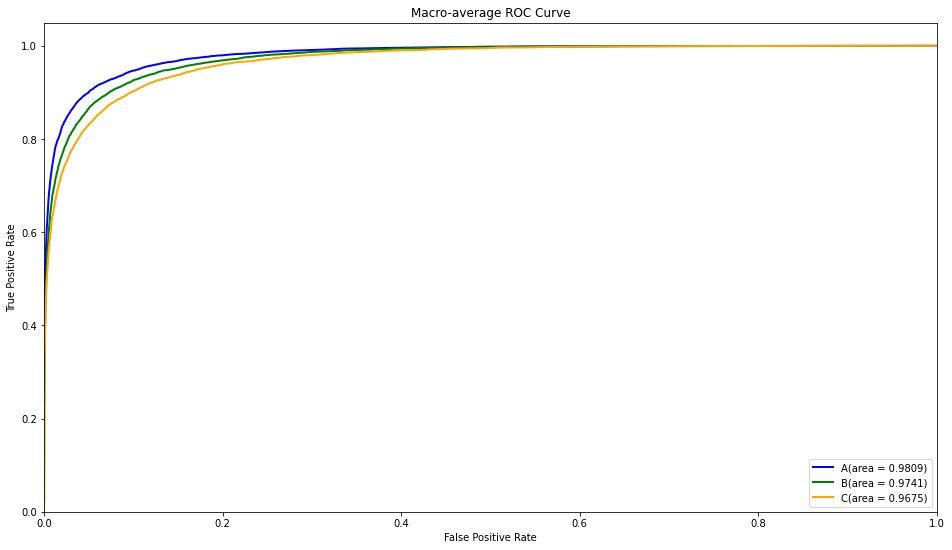

In [251]:
plt.figure(figsize=[16, 9])
lw = 2
colors = ['blue', 'green', 'orange']
for ind, model_name in enumerate(['A', 'B', 'C']):
    plt.plot(fpr[model_name]["macro"], tpr[model_name]["macro"], color=colors[ind],
            lw=lw, label=f'{model_name}(area = %0.4f)' % roc_auc[model_name]['macro'])
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve')
plt.legend(loc="lower right")
plt.savefig('macro_auc.png')
plt.show()

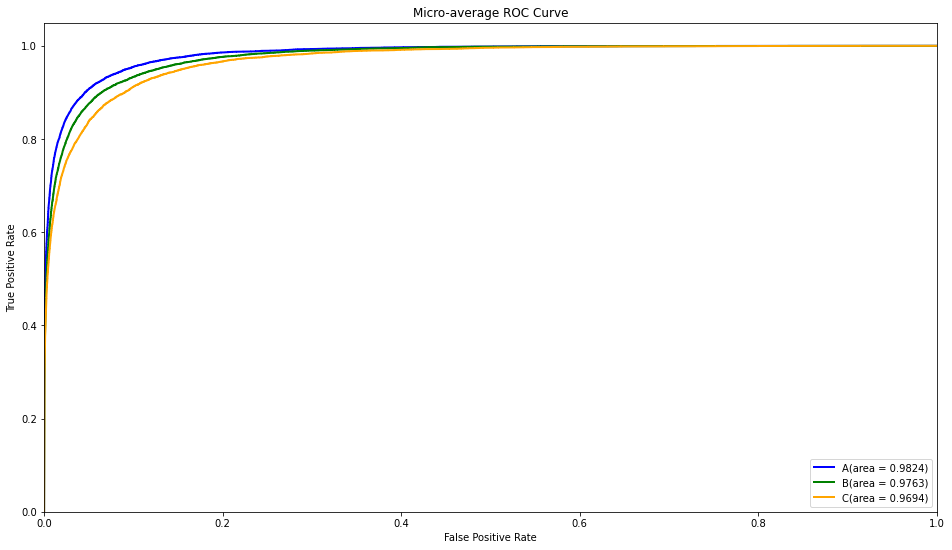

In [252]:
plt.figure(figsize=[16, 9])
lw = 2
colors = ['blue', 'green', 'orange']
for ind, model_name in enumerate(['A', 'B', 'C']):
    plt.plot(fpr[model_name]["micro"], tpr[model_name]["micro"], color=colors[ind],
            lw=lw, label=f'{model_name}(area = %0.4f)' % roc_auc[model_name]['micro'])
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend(loc="lower right")
plt.savefig('micro_auc.png')
plt.show()

In [276]:
y_test_label = np.where(y_test==1)[1]
y_test_pred_label_A = np.where(y_test_pred_A==1)[1]
y_test_pred_label_B = np.where(y_test_pred_B==1)[1]
y_test_pred_label_C = np.where(y_test_pred_C==1)[1]

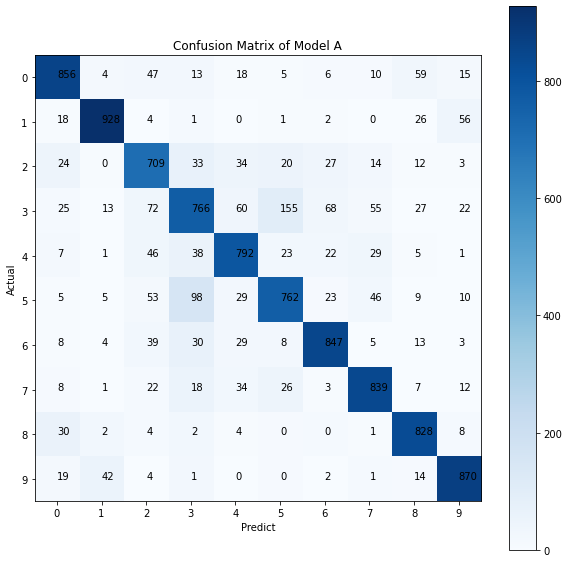

In [277]:
confusion_mat_A = confusion_matrix(y_test_label, y_test_pred_label_A)
plt.figure(figsize=[10, 10])
plt.imshow(confusion_mat_A, cmap=plt.cm.Blues)
indices = range(len(confusion_mat_A))
plt.xticks(indices, list(range(10)))
plt.yticks(indices, list(range(10)))
plt.colorbar()
plt.title('Confusion Matrix of Model A')
plt.xlabel('Predict')
plt.ylabel('Actual')
for first_index in range(len(confusion_mat_A)):
    for second_index in range(len(confusion_mat_A[first_index])):
        plt.text(first_index, second_index, confusion_mat_A[first_index][second_index])
plt.show()

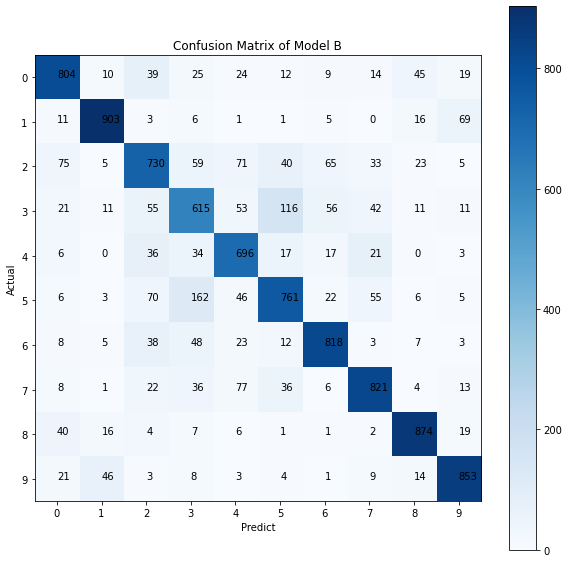

In [278]:
confusion_mat_B = confusion_matrix(y_test_label, y_test_pred_label_B)
plt.figure(figsize=[10, 10])
plt.imshow(confusion_mat_B, cmap=plt.cm.Blues)
indices = range(len(confusion_mat_B))
plt.xticks(indices, list(range(10)))
plt.yticks(indices, list(range(10)))
plt.colorbar()
plt.title('Confusion Matrix of Model B')
plt.xlabel('Predict')
plt.ylabel('Actual')
for first_index in range(len(confusion_mat_B)):
    for second_index in range(len(confusion_mat_B[first_index])):
        plt.text(first_index, second_index, confusion_mat_B[first_index][second_index])
plt.show()

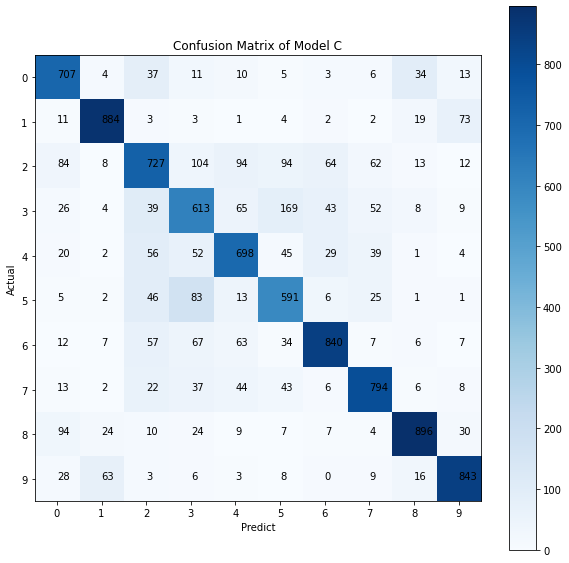

In [279]:
confusion_mat_C = confusion_matrix(y_test_label, y_test_pred_label_C)
plt.figure(figsize=[10, 10])
plt.imshow(confusion_mat_C, cmap=plt.cm.Blues)
indices = range(len(confusion_mat_C))
plt.xticks(indices, list(range(10)))
plt.yticks(indices, list(range(10)))
plt.colorbar()
plt.title('Confusion Matrix of Model C')
plt.xlabel('Predict')
plt.ylabel('Actual')
for first_index in range(len(confusion_mat_C)):
    for second_index in range(len(confusion_mat_C[first_index])):
        plt.text(first_index, second_index, confusion_mat_C[first_index][second_index])
plt.show()

In [263]:
y_test_label

array([3, 8, 8, ..., 5, 1, 7], dtype=int64)

In [264]:
y_test_pred_A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])